/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Accuracy: 0.6402877697841727
Random Forest Precision: 0.48863636363636365
Linear Regression Accuracy: 0.6474820143884892
Linear Regression Precision: 0.0
Precision with Rolling Averages: 0.625
Incorrectly Predicted Wins: 1    27
0    13
Name: actual_result_team, dtype: int64


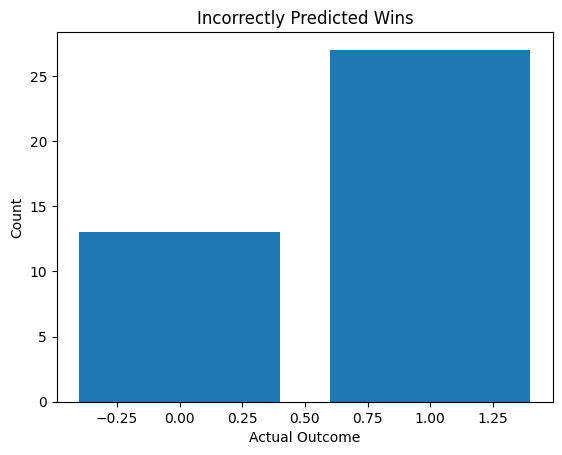

In [6]:
# Vaishnavi Shirsath
#COMP345 : Principles of Machine Learning
# Project
# Predicting Premier League wins

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
matches = pd.read_csv("epl_matches.csv", index_col=0)
matches["date"] = pd.to_datetime(matches["date"])

# Feature engineering
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
matches["day_code"] = matches["date"].dt.dayofweek
matches["target"] = (matches["result"] == "W").astype("int")

# Train-test split
train, test = train_test_split(matches, test_size=0.2, random_state=1)

# Random Forest
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
predictors = ["venue_code", "opp_code", "hour", "day_code"]
rf.fit(train[predictors], train["target"])
rf_preds = rf.predict(test[predictors])
rf_acc = accuracy_score(test["target"], rf_preds)
rf_precision = precision_score(test["target"], rf_preds)

# Linear Regression
lr = LogisticRegression(random_state=1)
lr.fit(train[predictors], train["target"])
lr_preds = lr.predict(test[predictors])
lr_acc = accuracy_score(test["target"], lr_preds)
lr_precision = precision_score(test["target"], lr_preds)

# Compare Random Forest and Linear Regression
print("Random Forest Accuracy:", rf_acc)
print("Random Forest Precision:", rf_precision)
print("Linear Regression Accuracy:", lr_acc)
print("Linear Regression Precision:", lr_precision)

# Rolling averages function
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed="left").mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

# Apply rolling averages to the dataset
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('team')
matches_rolling.index = range(matches_rolling.shape[0])

# Make predictions using rolling averages
def make_predictions(data, predictors):
    train = data[data["date"] < '2022-01-01']
    test = data[data["date"] > '2022-01-01']
    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    precision = precision_score(test["target"], preds)
    return combined, precision

# Make predictions using rolling averages
combined, precision = make_predictions(matches_rolling, predictors + new_cols)
print("Precision with Rolling Averages:", precision)

# Merge with original data for analysis
combined = combined.merge(matches_rolling[['date', "team", "opponent", "result"]], left_index=True, right_index=True)

# Rename columns for better clarity
combined.rename(columns={'actual': 'actual_result', 'predicted': 'predicted_result'}, inplace=True)


# Define MissingDict class
class MissingDict(dict):
    __missing__ = lambda self, key: key

# Mapping for team names
map_values = {
    "Brighton and Hove Albion": "Brighton",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves"
}

mapping = MissingDict(**map_values)
combined["new_team"] = combined["team"].map(mapping)

# Merge with itself based on date and new_team
merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"], suffixes=('_team', '_opponent'))

# Analysis of predicted outcomes
incorrect_predictions = merged[(merged["predicted_result_team"] == 1) & (merged["predicted_result_opponent"] == 0)]
incorrect_win_count = incorrect_predictions["actual_result_team"].value_counts()
print("Incorrectly Predicted Wins:", incorrect_win_count)

# Visualize incorrect predictions
plt.bar(incorrect_win_count.index, incorrect_win_count.values)
plt.xlabel("Actual Outcome")
plt.ylabel("Count")
plt.title("Incorrectly Predicted Wins")
plt.show()
